### The following notebook was used to unblind and compile all of the S1 data

In [20]:
# Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest as db

#### Reading in and cleaning up blinded metadata and compound key

In [21]:
md = pd.read_csv('C:/Users/Emily/Documents/S1/metadata/S1_metadata.csv', delimiter=',', encoding='utf-8-sig')
md['Compound library ID'] = md['Compound library ID'].str[-1]
#md.drop(md.columns[[3, 4, 12, 13, 16, 17, 18, 19, 20, 21]], axis = 1, inplace = True)
md = md.drop(md.index[0], axis=0)
md.head()

,Date:,Recorder,Plate ID,Different strains in each well of a single assay plate? (Y/N),Different compounds in each well of a single assay plate? (Y/N),Compound library ID,Compound Well A,Compound Well B,Compound Well C,Compound Well D,...,Chemotaxis Start (24 hrs format),Chemotaxis End (24 hrs format),Image ID,Scanner Slot:,Scanner Slot,Scanner #,Strain Well A,Strain Well B,Strain Well C,Strain Well D
1,8/23/21,Hodan,S1_R1_1,NaN,NaN,1,B2,B3,B4,B5,...,11:10,12:10,S1_001,1,NaN,3,N2,N2,N2,N2
2,8/23/21,Hodan,S1_R1_2,NaN,NaN,1,C2,C3,C4,C5,...,11:10,12:10,S1_001,2,NaN,3,N2,N2,N2,N2
3,8/23/21,Hodan,S1_R1_3,NaN,NaN,1,D2,D3,D4,D5,...,11:10,12:10,S1_001,3,NaN,3,N2,N2,N2,N2
4,8/23/21,Hodan,S1_R1_4,NaN,NaN,1,E2,E3,E4,E5,...,11:10,12:10,S1_001,4,NaN,3,N2,N2,N2,N2
5,8/23/21,Hodan,S1_R1_5,NaN,NaN,1,F2,F3,F4,F5,...,11:10,12:10,S1_002,1,NaN,4,N2,N2,N2,N2


In [22]:
compound_key = pd.read_csv('C:/Users/Emily/Documents/S1/metadata/S1_randomized_compounds.csv', index_col=0)
compound_key['Plate Number'] =  compound_key['Plate Number'].str.strip().str[-1]
compound_key.tail()


,CAS ID,Compound,Num,Let,Compound Well,Plate Number
91,137-32-6,2-Methyl-1-butanol,5,F,F5,4
92,3387-41-5,Sabinene,2,G,G2,4
93,462-94-2,Cadaverine,3,G,G3,4
94,105-87-3,Geranyl Acetate,4,G,G4,4
95,508-02-1,Oleanolic Acid,5,G,G5,4


#### Generating functions to unblind the compounds in the metadata

In [23]:
def add_compoundA(row, compound_map ):
    compound = compound_map.loc[
        (compound_map['Plate Number']==row['Compound library ID']) & 
        (compound_map['Compound Well']==row['Compound Well A'])]['Compound']
    return compound.values[0]

def add_compoundB(row, compound_map ):
    compound = compound_map.loc[
        (compound_map['Plate Number']==row['Compound library ID']) & 
        (compound_map['Compound Well']==row['Compound Well B'])]['Compound']
    #print(compound.values)
    return compound.values[0]

def add_compoundC(row, compound_map ):
    compound = compound_map.loc[
        (compound_map['Plate Number']==row['Compound library ID']) & 
        (compound_map['Compound Well']==row['Compound Well C'])]['Compound']
    return compound.values[0]

def add_compoundD(row, compound_map ):
    compound = compound_map.loc[
        (compound_map['Plate Number']==row['Compound library ID']) & 
        (compound_map['Compound Well']==row['Compound Well D'])]['Compound']
    return compound.values[0]

In [24]:
md['Compound A'] = md.apply(
    lambda row: add_compoundA(row, compound_key), axis=1)

md['Compound B'] = md.apply(
    lambda row: add_compoundB(row, compound_key), axis=1)
    
md['Compound C'] = md.apply(
    lambda row: add_compoundC(row, compound_key), axis=1)
    
md['Compound D'] = md.apply(
    lambda row: add_compoundD(row, compound_key), axis=1)

md['Scanner Slot:'] = md['Scanner Slot:'].apply(str)

#### Reading in the Image Analysis summary file. 
<p> The metadata sheet will be used to fill in missing fields on the Image Analysis summary file including Compound, Strain and Plate ID </p>

In [25]:
ia_data = pd.read_csv('C:/Users/Emily/Documents/S1/image_analysis/S1_All_reps.csv', index_col=0)
ia_data = ia_data.drop(['Large Object'], axis=1)

#### Calculating coefficiant of variation for the total number of worms dispensed by the liquid handler

In [26]:
t = ia_data['Total Worms'].describe()
print(t)
print('Coefficient of variation = '+str(t['std']/t['mean']*100))

count    312.000000
mean     281.314103
std       72.736392
min       83.000000
25%      223.750000
50%      280.000000
75%      334.250000
max      467.000000
Name: Total Worms, dtype: float64
Coefficient of variation = 25.85593511051879


#### Generating a function to add the plate ID and compound name to the summary data

In [27]:
def add_PlateID(row, metadata):
    slotID = row['WellNo'][0]
    pid = metadata.loc[
        (metadata['Image ID']==row['File Name']) & 
        (metadata['Scanner Slot:']==slotID)]['Plate ID']
    return pid.values[0]

In [28]:
ia_data['Plate ID'] = ia_data.apply(
    lambda row: add_PlateID(row, md), axis=1)

In [29]:
def add_Compound(row, metadata):
    wellID = row['WellNo'][1]
    if wellID == 'A':
        compound = metadata.loc[metadata['Plate ID']==row['Plate ID']]['Compound A']
    elif wellID == 'B':
        compound = metadata.loc[metadata['Plate ID']==row['Plate ID']]['Compound B']
    elif wellID == 'C':
        compound = metadata.loc[metadata['Plate ID']==row['Plate ID']]['Compound C']
    elif wellID == 'D':
        compound = metadata.loc[metadata['Plate ID']==row['Plate ID']]['Compound D']
    print(compound)
    return compound.values[0]

In [30]:
ia_data['Compound'] = ia_data.apply(
    lambda row: add_Compound(row, md), axis=1)

1    5-Aminolevulinic acid (hydrochloride)
Name: Compound A, dtype: object
1    Alyssin
Name: Compound B, dtype: object
1    Methyl palmitate
Name: Compound C, dtype: object
1    Safranal
Name: Compound D, dtype: object
2    Spinosad
Name: Compound A, dtype: object
2    Ellagic acid
Name: Compound B, dtype: object
2    Camphor
Name: Compound C, dtype: object
2    Citronellol
Name: Compound D, dtype: object
3    Rosmarinic acid
Name: Compound A, dtype: object
3    Kaempferol
Name: Compound B, dtype: object
3    Piperonyl Alcohol
Name: Compound C, dtype: object
3    Coumaran
Name: Compound D, dtype: object
4    Diacetyl
Name: Compound A, dtype: object
4    Guaiazulene
Name: Compound B, dtype: object
4    (-)-Huperzine A
Name: Compound C, dtype: object
4    L-Mimosine
Name: Compound D, dtype: object
5    Micheliolide
Name: Compound A, dtype: object
5    Beta caryophyllene
Name: Compound B, dtype: object
5    Salicylic acid
Name: Compound C, dtype: object
5    Nerolidol
Name: Compound D, d

Name: Compound C, dtype: object
61    Vincristine (sulfate)
Name: Compound D, dtype: object
62    L-Citrulline
Name: Compound A, dtype: object
62    Loganin
Name: Compound B, dtype: object
62    Daucosterol
Name: Compound C, dtype: object
62    (-)-Borneol
Name: Compound D, dtype: object
63    L-Ornithine
Name: Compound A, dtype: object
63    Anethole trithione
Name: Compound B, dtype: object
63    Myrcene
Name: Compound C, dtype: object
63    Pogostone
Name: Compound D, dtype: object
64    Octyle acetate
Name: Compound A, dtype: object
64    Lapachol
Name: Compound B, dtype: object
64    Cinnamyl Alcohol
Name: Compound C, dtype: object
64    2,3-Dihydrobenzofuran
Name: Compound D, dtype: object
53    Ajmalicine
Name: Compound A, dtype: object
53    Galanthamine
Name: Compound B, dtype: object
53    Bergapten
Name: Compound C, dtype: object
53    Eucalyptol
Name: Compound D, dtype: object
54    Ursolic acid
Name: Compound A, dtype: object
54    Solasodine
Name: Compound B, dtype: objec

#### Filtering the dataset to only include replicates with 150 worms or more
<p> We also want to identify any compounds with fewer than 3 biological replicates with over 150 worms<p>

In [31]:
ia_data = ia_data.loc[ia_data['Total Worms']>= 150] 
ia_data['comp_count'] = ia_data.groupby('Compound')['Compound'].transform('count')
ia_data.loc[ia_data['comp_count']<3] 

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,comp_count
0,1A,329.0,0.212121,Paeoniflorin,NaN,S1_005,3039.0,S1_R1_17,2
2,1C,313.0,0.828179,Isoamyl alcohol,NaN,S1_005,3030.0,S1_R1_17,2
10,3C,268.0,0.451327,Phenylacetylene,NaN,S1_011,3058.0,S1_R2_19,2
8,3A,227.0,0.431472,Paeoniflorin,NaN,S1_009,3050.0,S1_R2_11,2
10,3C,189.0,0.847059,Isoamyl alcohol,NaN,S1_009,3066.0,S1_R2_11,2
2,1C,228.0,0.215311,Phenylacetylene,NaN,S1_021,3024.0,S1_R4_7,2
3,1D,191.0,0.584270,2-Methyl-1-butanol,NaN,S1_017,3017.0,S1_R3_17,2
11,3D,190.0,0.780347,2-Methyl-1-butanol,NaN,S1_012,3055.0,S1_R2_23,2


#### Reading in all of the files that contain worm positions based on the exclusion criteria above

In [32]:
wrm_locs_fldr = plb.Path('C:/Users/Emily/Documents/S1/image_analysis/')

In [33]:
def get_worm_locs(row, wrms, result_dict, df): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound']
    xs = temp['X']
    mean_pos = xs.mean()
    df.loc[len(df.index)] = [compound, mean_pos] 
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict, df

In [36]:
ia_data = ia_data.sort_values(['Compound', 'File Name'], ascending=[True, True])
ia_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,comp_count
3,1D,387.0,0.095808,(+)-Carvone,NaN,S1_006,3055.0,S1_R1_21,3
11,3D,408.0,-0.041096,(+)-Carvone,NaN,S1_010,3047.0,S1_R2_15,3
11,3D,257.0,0.205021,(+)-Carvone,NaN,S1_013,3057.0,S1_R3_3,3
15,4D,325.0,-0.086667,(-)-Borneol,NaN,S1_011,3027.0,S1_R2_20,3
7,2D,203.0,0.088889,(-)-Borneol,NaN,S1_016,3048.0,S1_R3_14,3


In [45]:
r = ['Diacetyl', 'Isoamyl alcohol', '2-nonanone']
sub = ia_data[ia_data['Compound'].isin(r)]
submean = sub.groupby(['Compound']).mean()
subsd = sub.groupby(['Compound']).std()
subsd

,Total Worms,Chemotaxis,Strain,Well width,comp_count
Compound,,,,,
2-nonanone,55.865911,0.098474,NaN,4.358899,0.0
Diacetyl,34.530180,0.217693,NaN,14.189198,0.0
Isoamyl alcohol,87.681241,0.013350,NaN,25.455844,0.0


In [46]:
submean

,Total Worms,Chemotaxis,Strain,Well width,comp_count
Compound,,,,,
2-nonanone,289.000000,-0.246056,NaN,3053.000000,3
Diacetyl,265.333333,0.570664,NaN,3057.666667,3
Isoamyl alcohol,251.000000,0.837619,NaN,3048.000000,2


#### To perform statistical analyses we need to pool all of the worm positiions from each biological replicate for each condition.

<p> We also want to capture the first 3 biological replicates performed for each condition. Some conditions were captured 4 times due to errors made during the screening process <p>

In [25]:
# Need to create an empty dictionary to hold the values
results_dict = {}
mean_df = pd.DataFrame(columns=['Condition', 'MeanPos'])
compound = ''
i=0

for index, row in ia_data.iterrows():
    if row['Compound'] == compound:
        i += 1
        compound = row['Compound']
        if i < 3:
            pooled, means = get_worm_locs(row, wrm_locs_fldr, results_dict, mean_df)
        else:
            continue
    else:
        i = 0
        compound = row['Compound']
        pooled, means = get_worm_locs(row, wrm_locs_fldr, results_dict, mean_df)

    
#Remember that Dabest requires a dataframe. Casting dict to df
pooled_df = pd.DataFrame.from_dict(pooled)

#### Converting the worm locations from measurements in dots per inch to millimeters

In [27]:
middle = ia_data['Well width'].mean()/2

# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm

middle_mm = middle/px_mm

#The following transforms the worm location data so that it is respective to the start zone
# The start zone is at the center of the image; Start Zone = 0mm
#Worms with positive values are closer to the compound, negative values are away from the compound
mm_df = pooled_df.apply(lambda x: -(x/px_mm)+middle_mm)
#mm_df.to_csv('C:/Users/Emily/Documents/S1/S1_xs3.csv')

In [35]:
mm_df.to_csv('C:/Users/Emily/Documents/S1/S1_xs3.csv')

In [28]:
means['MeanPos'] = means['MeanPos'].apply(lambda x: -(x/px_mm)+32.5)

#### Creating an ordered list of compounds to pass to Dabest to calculate confidence intervals
<p> The control condition always needs to be the first item in the list

In [30]:
sums = ia_data.groupby('Compound').mean().reset_index()
ia_sort = sums.copy()
condition = (ia_sort.Compound=='DMSO') | (ia_sort.Compound=='H2O')

excluded = ia_sort[condition]
included = ia_sort[~condition]
sortd = included.sort_values(by='Chemotaxis',ascending=True)
ia_sort = pd.concat([excluded, sortd])

cmpd_ordr = ia_sort['Compound'].to_list()

In [32]:
means['Condition'] = pd.Categorical(means['Condition'], cmpd_ordr)
means.sort_values(by=['Condition'], inplace=True)

In [39]:
means.head()

,Condition,MeanPos
95,DMSO,0.140156
96,DMSO,-0.631922
97,DMSO,1.482885
134,H2O,-0.766887
135,H2O,2.589881


#### Generating confidence intervals using DMSO as the control group

In [33]:
db_obj = db.load(mm_df, idx=(cmpd_ordr))
pooled_mm_obj = db.load(mm_df, idx=(cmpd_ordr))
results_df_mm = pooled_mm_obj.mean_diff.results

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


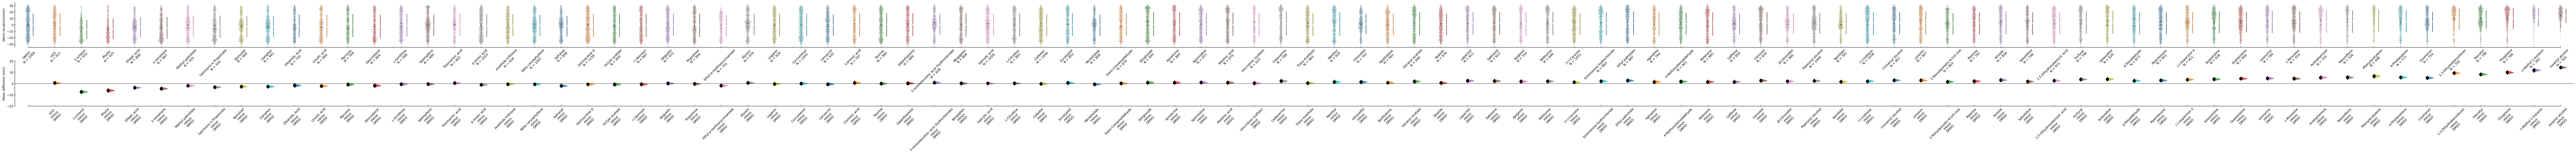

In [38]:
# Generating the plots
mm_plot = pooled_mm_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm locations(mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35))

#Accessing plot axes to control plot asthetics
rawswarm_axes = mm_plot.axes[0]
contrast_axes = mm_plot.axes[1]
rawswarm_axes.scatter(means.Condition, means.MeanPos, s=1,c='black')

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)

contrast_axes.yaxis.set_tick_params(tickdir='in')
contrast_axes.xaxis.set_tick_params(tickdir='in',rotation=45)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('C:/Users/Emily/Desktop/96meanPos.png')


#### Filtering the DMSO analysis for compounds with confidence intervals that do not span the mean of position of worms against DMSO

In [21]:
same = results_df_mm.loc[(results_df_mm['bca_low'] < 0) & (results_df_mm['bca_high'] > 0)]
same_comps = same['test'].to_list()
diff = results_df_mm[~results_df_mm['test'].isin(same_comps)]
diff = diff.append(results_df_mm.loc[results_df_mm['test']=='H2O'])
diff = diff.sort_values(['difference'])
diff

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
1,DMSO,1-octanol,1068,652,mean difference,False,-7.446258,95,-8.944625,-5.916856,...,5000,12345,0.0000,5000,1.049841e-21,9.717362,2.703217e-20,9.347132,1.296941e-18,436169.5
2,DMSO,Phytol,1068,625,mean difference,False,-6.248916,95,-7.800290,-4.622622,...,5000,12345,0.0000,5000,5.494421e-14,7.599271,1.175689e-13,7.481410,1.811060e-13,405215.0
4,DMSO,2-nonanone,1068,867,mean difference,False,-4.575976,95,-6.020000,-3.096992,...,5000,12345,0.0000,5000,1.936083e-09,6.032800,2.227250e-09,6.008853,3.639988e-09,535088.0
3,DMSO,Ellagic acid,1068,890,mean difference,False,-3.744019,95,-5.184462,-2.379066,...,5000,12345,0.0000,5000,2.462091e-07,5.178916,3.299728e-07,5.123185,2.051909e-06,534408.5
6,DMSO,Salvinorin A Propionate,1068,926,mean difference,False,-3.313405,95,-4.793185,-1.846934,...,5000,12345,0.0000,5000,1.228296e-05,4.383759,1.248376e-05,4.380002,1.484407e-05,550018.5
7,DMSO,Spinosad,1068,900,mean difference,False,-2.796940,95,-4.280256,-1.379054,...,5000,12345,0.0000,5000,1.844794e-04,3.746616,1.963781e-04,3.730681,3.352161e-04,525641.0
8,DMSO,Camphor,1068,941,mean difference,False,-2.756356,95,-4.166159,-1.342275,...,5000,12345,0.0004,5000,1.627035e-04,3.778015,1.743311e-04,3.760641,3.707904e-04,548684.0
10,DMSO,Ursolic acid,1068,884,mean difference,False,-2.229335,95,-3.737300,-0.736521,...,5000,12345,0.0036,5000,3.954668e-03,2.885328,3.934319e-03,2.886827,3.827441e-03,507905.5
19,DMSO,Safranal,1068,848,mean difference,False,-2.081202,95,-3.541572,-0.588647,...,5000,12345,0.0068,5000,5.298480e-03,2.791574,5.740397e-03,2.765370,9.653988e-03,483961.5
5,DMSO,Methyl palmitate,1068,935,mean difference,False,-1.978422,95,-3.417955,-0.566900,...,5000,12345,0.0062,5000,7.167672e-03,2.691734,7.404997e-03,2.680797,1.117691e-02,532054.0


In [22]:
print(len(diff))

54


#### Swapping the list order so that water is the control group

In [23]:
def swap_rows(df, i1, i2):
    a, b = df.iloc[0], df.iloc[1]
    df.iloc[i1, :], df.iloc[i2, :] = b, a
    return df

swapped = swap_rows(excluded, 0, 1)
h20_analysis = swapped.append(included)
h20_analysis.tail()

,Compound,Total Worms,Chemotaxis,Strain,Well width,comp_count
91,p-Anisic acid,341.333333,-0.076448,NaN,3046.333333,3
92,p-Tolualdehyde,291.000000,0.189825,NaN,3039.666667,3
93,trans-Cinnamaldehyde,293.000000,0.019462,NaN,3051.666667,3
94,α-Phellandrene,259.000000,0.341553,NaN,3045.333333,3
95,β-Citronellol,260.750000,0.122218,NaN,3038.000000,4


#### Calculating confidence intervals using water as the control group

In [25]:
h20_ordr = h20_analysis['Compound'].to_list()
h20_obj = db.load(mm_df, idx=(h20_ordr))
h20_md_results = h20_obj.mean_diff.results
h20_md_results

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,H2O,DMSO,915,1068,mean difference,False,-0.418416,95,-1.835136,1.079114,...,5000,12345,0.5740,5000,5.824984e-01,0.549831,5.826499e-01,0.549608,5.920424e-01,495422.0
1,H2O,(+)-Carvone,915,1052,mean difference,False,0.703972,95,-0.733226,2.151434,...,5000,12345,0.3566,5000,3.498650e-01,-0.935080,3.489966e-01,-0.936761,3.573942e-01,469726.0
2,H2O,(-)-Borneol,915,867,mean difference,False,-1.210954,95,-2.782015,0.362023,...,5000,12345,0.1438,5000,1.380134e-01,1.483902,1.375771e-01,1.485543,1.374698e-01,412778.5
3,H2O,(-)-Cedrene,915,1036,mean difference,False,1.584452,95,-0.021242,3.080056,...,5000,12345,0.0408,5000,4.176785e-02,-2.037181,4.222333e-02,-2.032649,3.555616e-02,447868.0
4,H2O,(-)-Huperzine A,915,911,mean difference,False,2.959551,95,1.392195,4.435206,...,5000,12345,0.0002,5000,1.086005e-04,-3.879056,1.088434e-04,-3.878473,2.309168e-04,375296.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,H2O,p-Anisic acid,915,1024,mean difference,False,-1.586643,95,-3.142784,-0.052098,...,5000,12345,0.0438,5000,4.107570e-02,2.044140,4.136976e-02,2.041164,3.869320e-02,493925.5
91,H2O,p-Tolualdehyde,915,873,mean difference,False,1.987114,95,0.397433,3.483390,...,5000,12345,0.0108,5000,1.113149e-02,-2.541192,1.120495e-02,-2.538883,1.454251e-02,372731.0
92,H2O,trans-Cinnamaldehyde,915,879,mean difference,False,-0.375126,95,-1.989382,1.223275,...,5000,12345,0.6526,5000,6.412641e-01,0.466011,6.411169e-01,0.466217,6.493164e-01,407130.5
93,H2O,α-Phellandrene,915,777,mean difference,False,4.949155,95,3.271456,6.519793,...,5000,12345,0.0000,5000,1.560789e-09,-6.072308,1.631275e-09,-6.064321,1.582380e-09,295028.0


In [26]:
results_df_mm = results_df_mm.append(h20_md_results)
#results_df_mm.to_csv('C:/Users/Emily/Documents/S1/S1_3.csv')

#### Filtering the water analysis for compounds with confidence intervals that do not span the mean of position of worms against water

In [27]:
h2o_same = h20_md_results.loc[(h20_md_results['bca_low'] < 0) & (h20_md_results['bca_high'] > 0)]
h2o_same_comps = h2o_same['test'].to_list()
h2o_diff = h20_md_results[~h20_md_results['test'].isin(h2o_same_comps)]
h2o_diff = h2o_diff.append(h20_md_results.loc[h20_md_results['test']=='DMSO'])
h2o_diff = h2o_diff.sort_values(['difference'])
h2o_diff

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
5,H2O,1-octanol,915,652,mean difference,False,-7.864674,95,-9.412386,-6.307701,...,5000,12345,0.0000,5000,1.665208e-22,9.917635,1.713584e-21,9.662233,4.284519e-20,379347.5
67,H2O,Phytol,915,625,mean difference,False,-6.667332,95,-8.326055,-4.998785,...,5000,12345,0.0000,5000,7.128956e-15,7.869332,1.233550e-14,7.788985,2.348864e-14,351323.5
10,H2O,2-nonanone,915,867,mean difference,False,-4.994392,95,-6.570856,-3.472582,...,5000,12345,0.0000,5000,2.586950e-10,6.358271,2.681458e-10,6.352614,3.667791e-10,464699.0
36,H2O,Ellagic acid,915,890,mean difference,False,-4.162435,95,-5.656421,-2.786431,...,5000,12345,0.0000,5000,3.452640e-08,5.541098,3.622312e-08,5.532369,1.157749e-07,465850.5
78,H2O,Salvinorin A Propionate,915,926,mean difference,False,-3.731821,95,-5.300717,-2.233021,...,5000,12345,0.0000,5000,2.020744e-06,4.766614,2.018779e-06,4.766807,1.964431e-06,477896.5
84,H2O,Spinosad,915,900,mean difference,False,-3.215357,95,-4.791870,-1.771035,...,5000,12345,0.0000,5000,3.409882e-05,4.154627,3.432489e-05,4.153093,4.517352e-05,457289.5
25,H2O,Camphor,915,941,mean difference,False,-3.174772,95,-4.717200,-1.695793,...,5000,12345,0.0000,5000,2.913837e-05,4.190629,2.862483e-05,4.194604,3.517555e-05,478262.5
88,H2O,Ursolic acid,915,884,mean difference,False,-2.647751,95,-4.195197,-1.069678,...,5000,12345,0.0006,5000,9.406416e-04,3.313218,9.385507e-04,3.313833,8.498876e-04,441176.5
75,H2O,Safranal,915,848,mean difference,False,-2.499618,95,-4.010133,-1.003454,...,5000,12345,0.0022,5000,1.244101e-03,3.233815,1.285597e-03,3.224376,1.404337e-03,422069.5
57,H2O,Methyl palmitate,915,935,mean difference,False,-2.396838,95,-3.896364,-0.889998,...,5000,12345,0.0020,5000,1.704080e-03,3.142115,1.692921e-03,3.144020,1.750989e-03,463713.5


In [28]:
print(len(h2o_diff))

44


#### Merging the water and DMSO analysis to reflect only compounds that are found in both analyses
<p> Compounds found on the resulting dataset will be retested using the the tax-4 null, osm-9 null and tax-4::osm-9 double null mutant strains

In [29]:
inner = pd.merge(h2o_diff, diff , on=["test"])
print(len(inner))

42


In [30]:
inner = inner.append(h2o_diff.loc[h2o_diff['test']=='DMSO'])
inner = inner.append(diff.loc[diff['test']=='H2O'])

In [31]:
print(len(results_df_mm))

190


In [32]:
comps = inner['test']
all_control_results = results_df_mm.loc[results_df_mm['test'].isin(comps)]
print(len(all_control_results))

86


In [34]:
all_control_results.to_csv('C:/Users/Emily/Documents/S1/inner3.csv')